In [1]:
import wfdb
import matplotlib.pyplot as plt
import scipy.signal
import numpy as np
import copy
import os
import itertools

In [2]:
sampfrom = 1300
#samp, rinfo = wfdb.rdsamp("data/drive12", channels=[0], sampfrom=sampfrom, sampto=sampfrom+100)
samp, rinfo = wfdb.rdsamp("data/drive12", channels=None, sampfrom=sampfrom, sampto=sampfrom+100)
samp = samp.flatten()

In [3]:
rinfo

{'fs': 15.5,
 'sig_len': 100,
 'n_sig': 7,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV', 'mV', 'mV', 'bpm', 'mV', 'mV'],
 'sig_name': ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'marker', 'RESP'],
 'comments': []}

In [4]:
def load_data(filename, channels=[0], sampfrom=0, sampto=1000):
    samp, rinfo = wfdb.rdsamp(filename, channels=channels, sampfrom=sampfrom, sampto=sampto)
    samp = samp.flatten()
    sr = rinfo["fs"]
    return sr, samp

def load_drive(n, channels=[0], sampfrom=0, sampto=1000):
    name = "drive%s" % str(n).zfill(2)
    filepath = os.path.join("data", name)
    return load_data(filepath, channels=channels, sampfrom=sampfrom, sampto=sampto)

def detect_peaks(X, N=5, area=3, rthreshold=50, pthreshold=90, do_plot=False):
    # N = 5 # N per seg
    
    # STFT
    WS = (N//2)+1 # Window samples
    f, t, Zxx = scipy.signal.stft(X, nperseg=N, noverlap=0)
    Zxx = np.abs(Zxx).reshape(-1, WS)
    
    # Detect RoIs
    wmax = np.max(Zxx, axis=1)
    thresholdF = np.percentile(wmax, rthreshold) #Nth percentile
    intervals = t[wmax > thresholdF]
    
    # Detect peaks
    thresholdP = np.percentile(X, pthreshold)
    peaks = []
    #area = 3 # additional search area aroud region
    for base in intervals.astype(int):
        if base >= X.size:
            continue
        if base > WS+area:
            base = base-WS-area
        end = base + N + area*2
        window = X[base:end]
        imax = np.max(window)
        if imax > thresholdP:
            peakT = base + np.argmax(window)
            if peakT in peaks:
                continue
            peaks.append(peakT)
    
    # Plot RoIs and peaks
    if do_plot:
        xmin = np.min(X)
        xmax = np.max(X)      
        plt.plot(X, linewidth=5, label="ECG")
        plt.vlines(intervals-WS-area, ymin=xmin, ymax=xmax, color="g", linewidth=0.5, label="roi start")
        plt.vlines(intervals+N+area*2, ymin=xmin, ymax=xmax, color="b", linewidth=0.5, label="roi end")
        plt.vlines(peaks, ymin=xmin, ymax=xmax, color="r", label="peak")
        plt.legend()
    
    return peaks

def trim_to_peak(X, sr, fail=True):
    sr = int(sr)
    peaks = detect_peaks(X[:sr*2])
    if not peaks and not fail:
        # If R peak not detected trim to max value in sr*2 interval
        print("No R peak detected -> trimming to max value in sr*2 interval")
        imax = np.argmax(X[:sr*2])
        return X[imax:]
    elif not peaks and fail:
        raise Exception("No peak detected")
        #return None
    peak = peaks[0]
    return X[peak:]

def resample(X, sr, tsr, trim=False):
    rate = tsr / sr
    xsize = X.size
    num = int(xsize * rate)
    rX = scipy.signal.resample(X, num)
    if trim:
        return rX[:xsize]
    return rX

def pair_signals(signals, srs):
    signals = copy.deepcopy(signals)
   
    # Resampling
    sr = srs[0]
    # Need to resample
    if np.min(srs) != np.max(srs):
        imaxsr = np.argmax(srs)
        maxsr = srs[imaxsr]
        sr = maxsr
        
        for i, (signal, ssr) in enumerate(zip(signals, srs)):
            print("Resampling %s" % i)
            if ssr == maxsr:
                continue
            rsignal = resample(signal, ssr, maxsr, trim=True)
            signals[i] = rsignal
            
    # R peak trim
    for i, (signal, ssr) in enumerate(zip(signals, srs)):
        print("Peak trimming %s" % i)
        signals[i] = trim_to_peak(signal, ssr, fail=False)
    
    # Resizing
    sizes = [s.size for s in signals]
    size = sizes[0]
    # Need to resize
    if np.min(sizes) != np.max(sizes): 
        iminsize = np.argmin(sizes)
        minsize = sizes[iminsize]
        size = minsize
        
        for i, (signal, size) in enumerate(zip(signals, sizes)):
            if size == minsize:
                continue
            print("Resizing %s" % i)
            signals[i] = signal[:minsize]
    
    return signals, sr, size

def rectify(s1):
    return np.abs(emg)

def integrate(s1, window_size):
    return np.convolve(remg, np.ones(window_size), mode="same")

def detect_changes(s1, window_size, threshold=0.01, do_plot=False):
    ts1 = s1[:s1.size - s1.size%window_size]
    
    changes = []
    for i, window in enumerate(np.split(ts1, ts1.size / window_size)):
        base = i * window_size
        end = (i+1) * (window_size) - 1

        grad = np.gradient(window)
        grad = np.sum(grad)

        if grad > threshold:
            changes.append( (base, end, True) )
            #plt.axvspan(base, end, color="green", alpha=0.5)
        elif grad < -threshold:
            changes.append( (base, end, False) )
            #plt.axvspan(base, end, color="red", alpha=0.5)
            
    if do_plot:
        plt.plot(ts1)
        for (base, end, rising) in changes:
            color = "green" if rising else "red"
            plt.axvspan(base, end, color=color, alpha=0.5)
            
    return changes

def correlate(s1, s2):
    return np.corrcoef(s1, s2)[0][1]

# Task 1 - heartrate detection

In [5]:
sr, signal = load_drive(12, sampfrom=0, sampto=250)

In [6]:
seconds = signal.size / sr
seconds

16.129032258064516

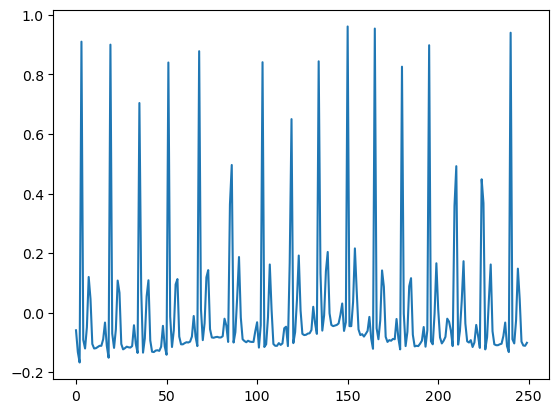

In [7]:
plt.plot(signal)

19
70.67999999999999


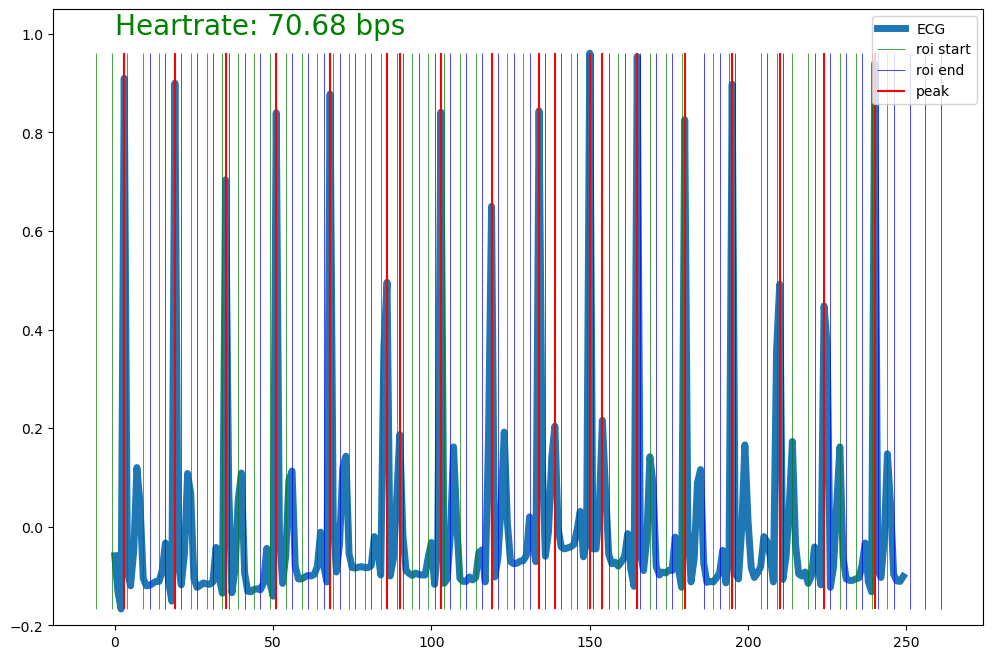

In [8]:
plt.figure(figsize=(12, 8))
peaks = detect_peaks(signal, N=5, rthreshold=5, pthreshold=90, do_plot=True)
npeaks = len(peaks)
print(npeaks)
pps = npeaks / seconds
hr = pps*60
print(hr)
plt.text(0, 1, "Heartrate: %.2f bps" % hr, fontdict={"size": 20, "color": "green"})
plt.ylim(-0.2, 1.05)
plt.legend(loc="upper right")

In [9]:
npeaks = len(peaks)

In [10]:
peakpersec = npeaks / seconds
peakpersec*60

70.67999999999999

# Task 2 - ECG correlation

In [11]:
drives = range(1, 12+1)
signals = []
srs = []
for drive in drives:
    sr, s = load_drive(drive)
    signals.append(s)
    srs.append(sr)

In [12]:
signals, sr, size = pair_signals(signals, srs)

Resampling 0
Resampling 1
Resampling 2
Resampling 3
Resampling 4
Resampling 5
Resampling 6
Resampling 7
Resampling 8
Resampling 9
Resampling 10
Resampling 11
Peak trimming 0
Peak trimming 1
Peak trimming 2
Peak trimming 3
Peak trimming 4
Peak trimming 5
Peak trimming 6
Peak trimming 7
Peak trimming 8
Peak trimming 9
Peak trimming 10
Peak trimming 11
Resizing 0
Resizing 1
Resizing 2
Resizing 3
Resizing 4
Resizing 6
Resizing 7
Resizing 8
Resizing 9
Resizing 10
Resizing 11


In [13]:
pairs = []

for i, s1 in enumerate(signals):
    for j, s2 in enumerate(signals):
        if i <= j:
            continue
        cor = correlate(s1, s2)
        print(i, j, cor)
        pairs.append((i, j, cor))

1 0 0.0344954832221225
2 0 -0.02345427299696706
2 1 -0.010509579312464877
3 0 0.17826710195805018
3 1 0.04884113595374902
3 2 0.016525372283830022
4 0 -0.042757002459058606
4 1 0.07595349355436952
4 2 -0.06954422772609528
4 3 0.07643265775282256
5 0 -0.01138876451192131
5 1 -0.0064547845161398755
5 2 0.055854207301292216
5 3 0.01923688333593771
5 4 -0.07791577176541606
6 0 0.10282221988116595
6 1 0.03442945457780073
6 2 0.06855117631118476
6 3 0.048753054432006525
6 4 0.031256590237459185
6 5 0.12069939319159471
7 0 -0.08753511029283889
7 1 0.0046511081039172985
7 2 -0.015860901320317176
7 3 -0.06715946601120251
7 4 0.03231048999766641
7 5 0.010443915976016665
7 6 -0.035399526235661345
8 0 0.06873994249575588
8 1 0.03137538889625133
8 2 0.05800404926203387
8 3 0.041958108466024574
8 4 -0.04745407760648964
8 5 -0.056263641666331805
8 6 0.0800891156379393
8 7 -0.0002681635789683512
9 0 0.04509878106067529
9 1 0.08382997556300106
9 2 -0.02497937832482669
9 3 0.07901988239765051
9 4 -0.068

In [14]:
sorted(pairs, key=lambda x: x[-1], reverse=True)

[(3, 0, 0.17826710195805018),
 (6, 5, 0.12069939319159471),
 (10, 5, 0.10401712770159253),
 (6, 0, 0.10282221988116595),
 (11, 6, 0.10021243488471253),
 (9, 1, 0.08382997556300106),
 (11, 10, 0.08085040377054012),
 (10, 9, 0.08042029284205206),
 (8, 6, 0.0800891156379393),
 (9, 3, 0.07901988239765051),
 (4, 3, 0.07643265775282256),
 (4, 1, 0.07595349355436952),
 (8, 0, 0.06873994249575588),
 (6, 2, 0.06855117631118476),
 (9, 6, 0.06422935262600839),
 (11, 8, 0.06327092864382211),
 (8, 2, 0.05800404926203387),
 (5, 2, 0.055854207301292216),
 (3, 1, 0.04884113595374902),
 (6, 3, 0.048753054432006525),
 (10, 4, 0.045470123835157264),
 (9, 0, 0.04509878106067529),
 (9, 5, 0.044942228420783166),
 (8, 3, 0.041958108466024574),
 (11, 7, 0.035855971796872575),
 (10, 0, 0.03498929775320727),
 (1, 0, 0.0344954832221225),
 (6, 1, 0.03442945457780073),
 (7, 4, 0.03231048999766641),
 (11, 9, 0.03218991324443391),
 (10, 3, 0.03152617224434459),
 (8, 1, 0.03137538889625133),
 (6, 4, 0.031256590237459

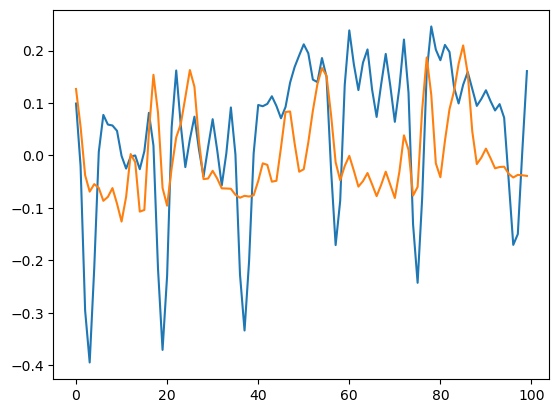

In [15]:
plt.plot(signals[0][:100])
plt.plot(signals[3][:100])

# Task 3 - EMG change detection

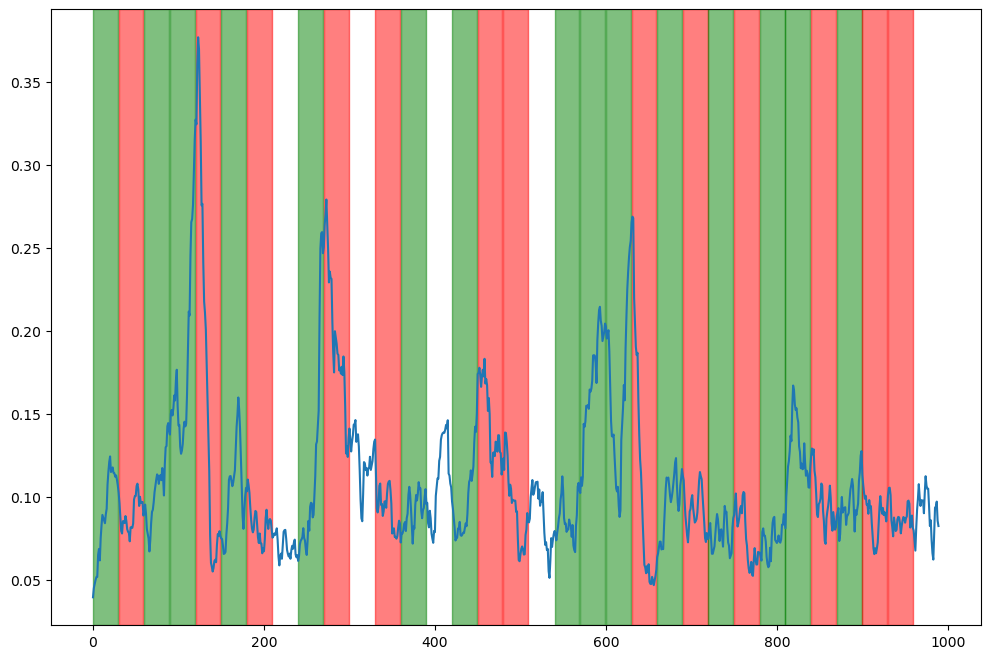

In [16]:
sr, emg = load_drive(1, channels=[1])
# Rectify
remg = rectify(emg)
# Integrate
iremg = integrate(remg, int(sr))

plt.figure(figsize=(12, 8))
_ = detect_changes(iremg, int(sr)*2, do_plot=True)